# Compressibility

Cardiac tissue is often modelled as a nearly incompressible or a fully incompressible material.

A nearly incompressible material can be modeled using a penalty formulation of volume changes. This might be considered the most physiological correct option. It has been demonstrated that the cells, which mostly consist of water, are around 100–1000 times more incompressible than the matrix surrounding them. On the other hand, a fully incompressible model is a common simplification – which has certain numerical advantages. Here, however, we don't separate between the two subdomains – and we assume a continuous pressure field across the membrane.

In the papers we haven't compared the two methods – but, as we will see later, it matters quite a bit, especially for the stress values. Let's start, as usual, by importing the relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


... and load the meshes and geometries:

In [2]:
mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364


## Fundamental equations

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We are, essentially, solving for a three-dimensional version of Newton's third law, expressed by Piola-Kirchhoff stress tensor $\mathbf{P}$:

$$\nabla \cdot \mathbf{P} = 0$$

Earlier we have seen how this can be decomposed into an active and a passive part, and how different material models can be used for the passive part. There is, however, one more term to take into account - a term for the compressibility model.

Using a nearly incompressible model, we calculate the volume change $J = \mathrm{det} (\mathbf{F})$, and add a penalty term:

\begin{equation}
\psi* = \psi + \kappa (J \ln J - J + 1)
\end{equation}

– and when calculating $\mathbf{P}$ we use $\psi*$ instead of $\psi$. $\kappa$ is a parameter which we can define differently over each subdomain, as $\kappa_i$ and $\kappa_e$. It has been demonstrated experimentally that the intracellular subdomain is 100–1000 times more compressible than the extracellular subdomain (citation needed).

## Comparing the compressibility models:

We will try out the different compressibility models doing an active contraction experiment:

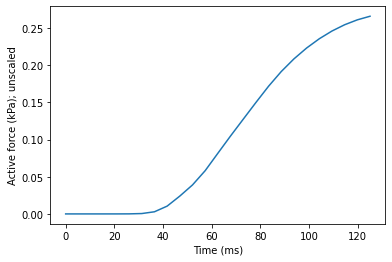

In [8]:
time = np.linspace(0, 500, 125)       # 500 ms with 125 steps

active_precomputed, _ = emi_m.compute_active_component(time)
active_precomputed *= 2

plt.plot(time, active_precomputed)
plt.xlabel("Time (ms)")
plt.ylabel("Active force (kPa); unscaled")
plt.show()

We will next define two instances of the model, one using a nearly incompressible and one using a fully incompressible approach – and track the fiber direction strain and stresses for comparison. Note that, as demonstrated here, you can specify the compressibility parameters for each subdomain, which only works using the nearly incompressible approach.

length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
Simulating 1 / 25
Simulating 11 / 25
Simulating 21 / 25
Simulating 1 / 25
Simulating 11 / 25
Simulating 21 / 25


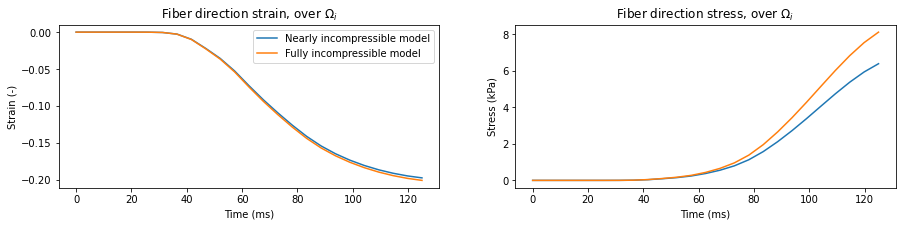

In [11]:
emi_model_incompressible = emi_m.EMIModel(
    mesh,
    volumes,
    experiment="contraction",
    compressibility_model="incompressible",
    )

emi_model_nearly_incompressible = emi_m.EMIModel(
    mesh,
    volumes,
    experiment="contraction",
    compressibility_model="nearly_incompressible",
    compressibility_parameters = {"kappa_e" : 100, "kappa_i" : 10000},
    )

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

for emimodel in [emi_model_incompressible, emi_model_nearly_incompressible]:
    fiber_dir_strain_i = np.zeros_like(active_precomputed)
    fiber_dir_stress_i = np.zeros_like(active_precomputed) 
    subdomain_id = 1         # intracellular subdomain

    # then run the simulation
    for step, a_str in enumerate(active_precomputed):
    
        if (step+1) % 10 == 1:
            print(f"Simulating {step + 1} / {len(active_precomputed)}")

        emimodel.update_active_fn(a_str)
        emimodel.solve()
    
        fiber_dir_strain_i[step] = \
            emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
        fiber_dir_stress_i[step] = \
            emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)

    axes[0].plot(time, fiber_dir_strain_i)
    axes[1].plot(time, fiber_dir_stress_i)
        
axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

axes[0].legend(["Nearly incompressible model", "Fully incompressible model"])
axes[1].legend(["Nearly incompressible model", "Fully incompressible model"])

plt.show()

In similar manners we can track stresses and strain values in the extracellular subdomain, identified with the number $0$. We also have in-built functions for tracking sheet and normal direction values, using functions <code>evaluate_subdomain_strain_sheet_dir</code>, <code>evaluate_subdomain_strain_normal_dir</code>, <code>evaluate_subdomain_stress_sheet_dir</code>, and <code>evaluate_subdomain_stress_normal_dir</code>.